# Global Map of EBC's
Creating a global projection of important mean-state variables: SLP, surface wind stress, SSTs, and placing boxes over the regions that are being investigated. This gives the reader/viewer an idea of where we are working and why these systems are important.

In [1]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap

# Create NetCDFs of Ensemble Means
- Storing the global surface ensemble means away as NetCDFs to make processing faster. I don't want to do this with the EBUS_extraction scripts, since we are trying to get a global perspective.
- Historical means, i.e. 1920-2015

# Ocean Output

In [2]:
VAR = 'TAUY'

In [3]:
fileDir = '/glade/scratch/rbrady/EBUS_BGC_Variability/' + VAR + '_monthly/'
ds = xr.open_mfdataset(fileDir + 'reduced*.nc', decode_times=False, concat_dim='ensemble')

In [4]:
pandaTimes = pd.date_range('1920-01', '2101-01', freq='M')
ds.coords['time'] = pandaTimes
ds.attrs = {}

In [5]:
#ds = ds.sel(time=slice('1920-1', '2015-12'))

# For landschuetzer time period
ds = ds.sel(time=slice('1982-01', '2011-12'))

In [6]:
da = ds[VAR].mean(dim='ensemble').mean(dim='time')
da = da.squeeze()

In [7]:
ds_out = da.to_dataset()
if VAR == 'TAUX' or VAR == 'TAUY':
    ds_out['ANGLE'] = ds['ANGLE'][0]
else:
    ds_out.coords['TLAT'] = ds['TLAT'][0]
    ds_out.coords['TLONG'] = ds['TLONG'][0]

In [8]:
outDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
ds_out.to_netcdf(outDir + VAR + '-ensemble-landschuetzer-mean-global.nc')

/glade/u/home/rbrady/.local/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
inDir ='/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
filename = 'SST-ensemble-historical-mean-global.nc'
ds = xr.open_dataset(inDir + filename)

# Atmosphere Output

In [ ]:
VAR = 'PSL'

In [ ]:
fileDir = '/glade/scratch/rbrady/EBUS_BGC_Variability/' + VAR + '_monthly/'
ds = xr.open_mfdataset(fileDir + 'reduced*.nc', concat_dim='ensemble')

In [ ]:
ds = ds.drop('nbnd')

In [ ]:
ds.attrs = {}

In [ ]:
ds = ds.sel(time=slice('1920-01', '2015-12'))

In [ ]:
ds = ds['PSL'].mean(dim='ensemble').mean(dim='time')

In [ ]:
ds = ds/100

In [ ]:
ds = ds.squeeze()

In [ ]:
LON,LAT = np.meshgrid(ds.lon.values, ds.lat.values)

In [ ]:
ds.coords['LON'] = (('lat','lon'), LON)
ds.coords['LAT'] = (('lat','lon'), LAT)

In [ ]:
ds = ds.to_dataset()

In [ ]:
outDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
ds.to_netcdf(outDir + VAR + '-ensemble-historical-mean-global.nc')

# Visualization Functions

In [2]:
def setup_map(ax):
    m = Basemap(projection='robin',
                lon_0=0,
               resolution='c')
    #m.drawcoastlines()
    m.fillcontinents(color='k')
    m.drawparallels(np.arange(-90,120.,15.))
    m.drawmeridians(np.arange(0.,360.,60.))
    m.drawcoastlines(color='k')
    #m.drawcountries()
    #m.fillcontinents(color='#D3D3D3')
    m.drawmapboundary(fill_color='white')
    return m

In [3]:
def load_global_field(VAR):
    inDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
    fileName = VAR + '-ensemble-historical-mean-global.nc'
    ds = xr.open_dataset(inDir + fileName)
    return ds

In [4]:
def visual_bounds(EBU):
    if EBU == "CalCS":
        lat1 = 25
        lat2 = 43
        lon1 = -133+360
        lon2 = -110+360
    elif EBU == 'HumCS':
        lat1 = -20
        lat2 = -2
        lon1 = -90
        lon2 = -70
    elif EBU == 'CanCS':
        lat1 = 10
        lat2 = 28
        lon1 = -25
        lon2 = -10
    elif EBU == 'BenCS':
        lat1 = -35
        lat2 = -15
        lon1 = 5
        lon2 = 20
    return lat1,lat2,lon1,lon2

In [5]:
def find_indices(latGrid, lonGrid, latPoint, lonPoint):
    dx = lonGrid - lonPoint
    dy = latGrid - latPoint
    reducedGrid = abs(dx) + abs(dy)
    min_ix = np.nanargmin(reducedGrid)
    i, j = np.unravel_index(min_ix, reducedGrid.shape)
    return i, j

In [192]:
from matplotlib.patches import Polygon
def draw_screen_poly(lats, lons, m):
    x, y = m(lons, lats)
    xy = zip(x,y)
    poly = Polygon( xy, edgecolor='w', facecolor='none', linewidth= )
    plt.gca().add_patch(poly)

# Visualization Code

In [103]:
# Load in data
ds_sst = load_global_field('SST')
ds_psl = load_global_field('PSL')
ds_taux = load_global_field('TAUX')
ds_tauy = load_global_field('TAUY')

# Set up coordinates
alat = ds_psl['LAT'].values
along = ds_psl['LON'].values
tlong = ds_sst['TLONG'].values
tlat = ds_sst['TLAT'].values
ulong = ds_taux['ULONG'].values
ulat = ds_taux['ULAT'].values
angle = ds_taux['ANGLE'].values

# Set up data
sst = ds_sst['SST'].values
psl = ds_psl['PSL'].values
taux = ds_taux['TAUX'].values
tauy = ds_tauy['TAUY'].values

# Rotate winds for flat projection.
u = taux*np.cos(angle) - tauy*np.sin(angle) 
v = taux*np.sin(angle) + tauy*np.cos(angle) 

In [154]:
# Drop winds in the Southern Ocean
mask = ( ulat < -50 )
u2 = u.copy()
v2 = v.copy()
u2[mask] = np.nan
v2[mask] = np.nan

In [160]:
# Convert to N/m2
u2 = u2 * 100 * 100 / 10**5
v2 = v2 * 100 * 100 / 10**5

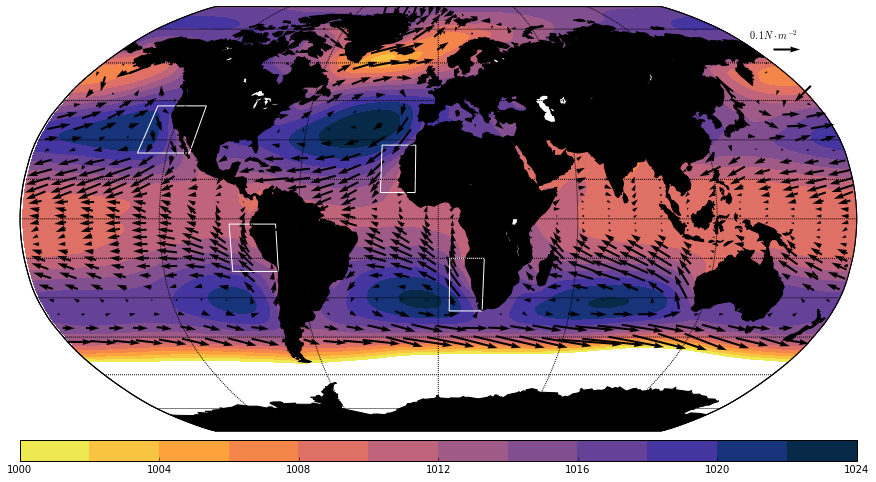

In [193]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
m = setup_map(ax)

# Pressure
m.contourf(along, alat, psl, np.arange(1000, 1026, 2),
          latlon=True, cmap=cmocean.cm.thermal_r)
m.colorbar(location='bottom')

# Winds
num=10
Q = m.quiver(ulong[::num,::num], ulat[::num,::num], u2[::num,::num], v2[::num,::num], 
             latlon=True, scale_units='width', pivot='mid')
qk = plt.quiverkey(Q, 0.9, 0.9, 0.1, r'$0.1 N\cdot m^{-2}$', labelpos='N',
                   coordinates='axes')

# Draw boxes on EBU's
EBUS = ['CalCS', 'HumCS', 'CanCS', 'BenCS']
for idx in EBUS:
    lat1, lat2, lon1, lon2 = visual_bounds(idx)
    lats = [ lat1, lat2, lat2, lat1 ]
    lons = [ lon1, lon1, lon2, lon2 ]
    draw_screen_poly(lats, lons, m)
plt.savefig('global_map_noTrans.eps', transparent=True, format='eps', 
            bbox_inches='tight', pad_inches=1, dpi=1000)

# Practicing Plotting Vectors

In [ ]:
lat1,lat2,lon1,lon2 = visual_bounds('CalCS')
a, c = find_indices(ulat, ulong, lat1, lon1)
b, d = find_indices(ulat, ulong, lat2, lon2)
datx = taux[a:b, c:d]
daty = tauy[a:b, c:d]
ulat = ulat[a:b, c:d]
ulon = ulong[a:b, c:d]
rot = angle[a:b,c:d]

a, c = find_indices(alat, along, lat1, lon1)
b, d = find_indices(alat, along, lat2, lon2)
psl = psl[a:b, c:d]
alat = alat[a:b, c:d]
alon = along[a:b, c:d]

# Rotate winds
uNew = datx*np.cos(rot) - daty*np.sin(rot) 
vNew = datx*np.sin(rot) + daty*np.cos(rot) 

In [ ]:
fig = plt.figure(figsize=(6,6))
# Practicing with winds.
m = Basemap(projection='merc',
                lat_0=(lat1+lat2)/2,
                lon_0=(lon1+lon2)/2,
                llcrnrlon=lon1,
                urcrnrlon=lon2,
                llcrnrlat=lat1,
                urcrnrlat=lat2,
                fix_aspect=False,
                resolution='c')
m.drawcoastlines(color='#D3D3D3')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(lat1, lat2+1, 3),
                   labels=[False,True,False,False], size=20,
                   color='b')
m.drawmeridians(np.arange(lon1, lon2+1, 3),
                   labels=[False, False, False, False], size='x-large',
                   color='b')
###
#Q = plt.quiver(X, Y, U, V, units='width')
m.contourf(alon, alat, psl, np.arange(1000,1026,1), latlon=True, cmap="RdBu")
Q = m.quiver(ulon, ulat, uNew, vNew, latlon=True, units='inches')
#qk = plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
#                   coordinates='figure')
